# Hands-On 5: Basic Hybrid Application MPI+OpenMP
*   Enzo Bacelar Conte Gebauer
*   Luiz Guilherme Guerreiro
*   Maria Eduarda Lopes de Morais Brito

## Plot function for OMP analysis

In [1]:
import matplotlib.pyplot as plt
from collections import defaultdict

def plot_function_openmp(file_path):
    # Function to load the data
    def load_data(file_name):
        data = {}
        with open(file_name, 'r') as file:
            for line in file:
                values = line.split()
                for i in range(0, len(values), 3):
                    size = float(values[i])
                    time = float(values[i + 1])
                    threads = int(values[i + 2])
                    if threads not in data:
                        data[threads] = defaultdict(list)
                    data[threads][size].append(time)

        # Calculating the average times for each size
        for thread, size_times in data.items():
            data[thread] = [(size, sum(times)/len(times)) for size, times in size_times.items()]

        return data

    data = load_data(file_path)

    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Time vs. Size
    markers = ['o', 's', '^', 'd', 'x', 'p', 'h', '+']
    for i, (threads, values) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        values.sort()
        sizes = [v[0] for v in values]
        times = [v[1] for v in values]
        axs[0].plot(sizes, times, label=f'Thread {threads}', marker=markers[i % len(markers)], markersize=7)

    axs[0].set_xlabel('Size')
    axs[0].set_ylabel('Time')
    axs[0].set_title('Time vs Size for Different Threads')
    axs[0].legend(loc='upper left')

    # Plot 2: Speedup
    times_1_thread = [v[1] for v in sorted(data[1], key=lambda x: x[0])]
    sizes = [v[0] for v in sorted(data[1], key=lambda x: x[0])]

    for i, (threads, values) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        if threads != 1:  # we do not compare the case with 1 thread with itself
            other_times = [v[1] for v in sorted(values, key=lambda x: x[0])]
            speedup = [t1 / to for t1, to in zip(times_1_thread, other_times)]
            axs[1].plot(sizes, speedup, label=f'Speedup {threads}x', marker=markers[i % len(markers)], markersize=7)

    axs[1].set_xlabel('Size')
    axs[1].set_ylabel('Speedup')
    axs[1].set_title('Speedup Compared to 1 Thread')
    axs[1].legend(loc='upper left')

    plt.tight_layout()
    plt.show()


## Plot function for MPI


In [2]:
import matplotlib.pyplot as plt

def plot_function_mpi(file_name):
    # Read the file and store the data
    data = {}
    with open(file_name, 'r') as file:
        for line in file:
            values = line.split()
            for i in range(0, len(values), 3):
                size = float(values[i])
                time = float(values[i + 1])
                processes = int(values[i + 2])
                if processes in data:
                    data[processes].append((size, time))
                else:
                    data[processes] = [(size, time)]

    # Line style options for the plot
    styles = ['o-', 's-', '^-', 'd-', 'x-', 'p-', 'h-', '+-']

    # Create subplots
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))

    # Plot 1
    for i, (processes, values) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        values.sort(key=lambda x: x[0])  # Sort by size
        sizes = [x[0] for x in values]
        times = [x[1] for x in values]
        axs[0].plot(sizes, times, styles[i % len(styles)], label=f'Processes: {processes}')

    # Configure the first plot
    axs[0].set_xlabel('Problem Size')
    axs[0].set_ylabel('Time')
    axs[0].set_title('Time vs Problem Size for Different Numbers of Processes')
    axs[0].legend()

    # Plot 2 - Speedup comparing 1 process with all others
    times_1_process = [x[1] for x in sorted(data[1], key=lambda x: x[0])]
    sizes = [x[0] for x in sorted(data[1], key=lambda x: x[0])]

    for i, (processes, values) in enumerate(sorted(data.items(), key=lambda x: x[0])):
        if processes != 1:  # we do not compare the case with 1 process with itself
            other_times = [x[1] for x in sorted(values, key=lambda x: x[0])]
            speedup = [t1 / to for t1, to in zip(times_1_process, other_times)]
            axs[1].plot(sizes, speedup, styles[i % len(styles)], label=f'Speedup {processes}x')

    # Configure the second plot
    axs[1].set_xlabel('Problem Size')
    axs[1].set_ylabel('Speedup')
    axs[1].set_title('Speedup Compared to 1 Process')
    axs[1].legend()

    # Adjust the layout and show the plots
    plt.tight_layout()
    plt.show()


## Plot function for OMP + MPI

In [96]:
import matplotlib.pyplot as plt

def plot_function_mpi_openmp(file_name):
    # Read the data from the file
    with open(file_name, 'r') as f:
        lines = f.readlines()

    # Process the data
    data = [[float(val) for val in line.split()] for line in lines]

    # Creating figure and axes with different sizes
    fig, axs = plt.subplots(2, 1, figsize=(10, 14), gridspec_kw={'height_ratios': [1.5, 1]})

    # Setting markers for the lines
    markers = ['o', 's', 'v', '^', '<', '>', 'p', '*', 'H', '+', 'x', 'D']

    # Plot 1: Comparison of all executions
    for i, line in enumerate(data):
        sizes = line[0::4]
        times = line[1::4]
        threads = line[2]
        processes = line[3]
        axs[0].plot(sizes, times, label=f'{threads} Threads, {processes} Processes', marker=markers[i % len(markers)])

    axs[0].set_xlabel('Problem Size', fontsize=12)
    axs[0].set_ylabel('Time', fontsize=12)
    axs[0].set_title('Comparison of All Executions', fontsize=14)
    axs[0].legend(loc='upper left', fontsize=10)

    # Plot 2: Comparison between 1 thread 1 process and other executions
    reference_line = data[0]
    sizes_ref = reference_line[0::4]
    times_ref = reference_line[1::4]

    for i, comparison_line in enumerate(data[1:-1]):  # Exclude the first and last lines
        sizes_comp = comparison_line[0::4]
        times_comp = comparison_line[1::4]

        # Calculating speedup as: reference_time / comparison_time
        speedup = [ref/comp for ref, comp in zip(times_ref, times_comp)]

        axs[1].plot(sizes_ref, speedup, label=f'Speedup: {comparison_line[2]} Threads, {comparison_line[3]} Processes', marker=markers[i % len(markers)])

    axs[1].set_xlabel('Problem Size', fontsize=12)
    axs[1].set_ylabel('Speedup', fontsize=12)
    axs[1].set_title('Speedup: 1 Thread 1 Process vs Other Configurations', fontsize=14)
    axs[1].legend(loc='upper left', fontsize=10)

    # Adjust layout
    plt.subplots_adjust(hspace=0.4)  # Adjust the height space between plots
    plt.tight_layout()
    plt.show()


##  `Matrix Multiple Benchmarks`

### OpenMP

In [4]:
%%writefile ./mm-openmp.c
#include <stdio.h>
#include <stdlib.h>
#include <omp.h>

void writeResultsToFile(int size, double time_spend, int num_threads) {
    FILE *output_file = fopen("./mm_openMP.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    }

    fprintf(output_file, "%d %lf %d ", size, time_spend, num_threads);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void initializeMatrix(int *matrix, int size)
{
  for (int i = 0; i < size; i++)
    for (int j = 0; j < size; j++)
      matrix[i * size + j] = rand() % (10 - 1) * 1;
}

void printMatrix(int *matrix, int size)
{
  for (int i = 0; i < size; i++)
  {
    for (int j = 0; j < size; j++)
      printf("%d\t", matrix[i * size + j]);
    printf("\n");
  }
  printf("\n");
}

int main (int argc, char **argv)
{

 int size = atoi(argv[1]);
 int i, j, k;
 double t0, tf;

 int  *A = (int *) malloc (sizeof(int)*size*size);
 int  *B = (int *) malloc (sizeof(int)*size*size);
 int  *C = (int *) malloc (sizeof(int)*size*size);

 initializeMatrix(A, size);
 initializeMatrix(B, size);

 t0 = omp_get_wtime();

  int num_threads = 0;

 #pragma omp parallel for private(i, j, k)
  for(i = 0; i < size; i++){
    for(j = 0; j < size; j++){
      for(k = 0; k < size; k++){
        C[i * size + j] += A[i * size + k] * B[k * size + j];
        if(i==0 && j==0 && k == 0)num_threads = omp_get_num_threads();
      }
    }
  }

 tf = omp_get_wtime();

//printf("%d\t%f\n",size, tf-t0);

// printMatrix(A,size);
// printMatrix(B,size);
// printMatrix(C,size);

writeResultsToFile(size, tf-t0, num_threads);

 return 0;

}

Writing ./mm-openmp.c


#### Run the code

In [5]:
!gcc ./mm-openmp.c -o ./mm -fopenmp

# Performance analysis

In [6]:
%%writefile ./script_mm_openMP.sh
#!/bin/sh

for ((i=1; i<=8; i++))
do
  for ((j=200; j<=1000; j+=200))
  do
    OMP_NUM_THREADS="$i" ./mm "$j"
  done
  echo
done

Writing ./script_mm_openMP.sh


In [7]:
!bash ./script_mm_openMP.sh




^C


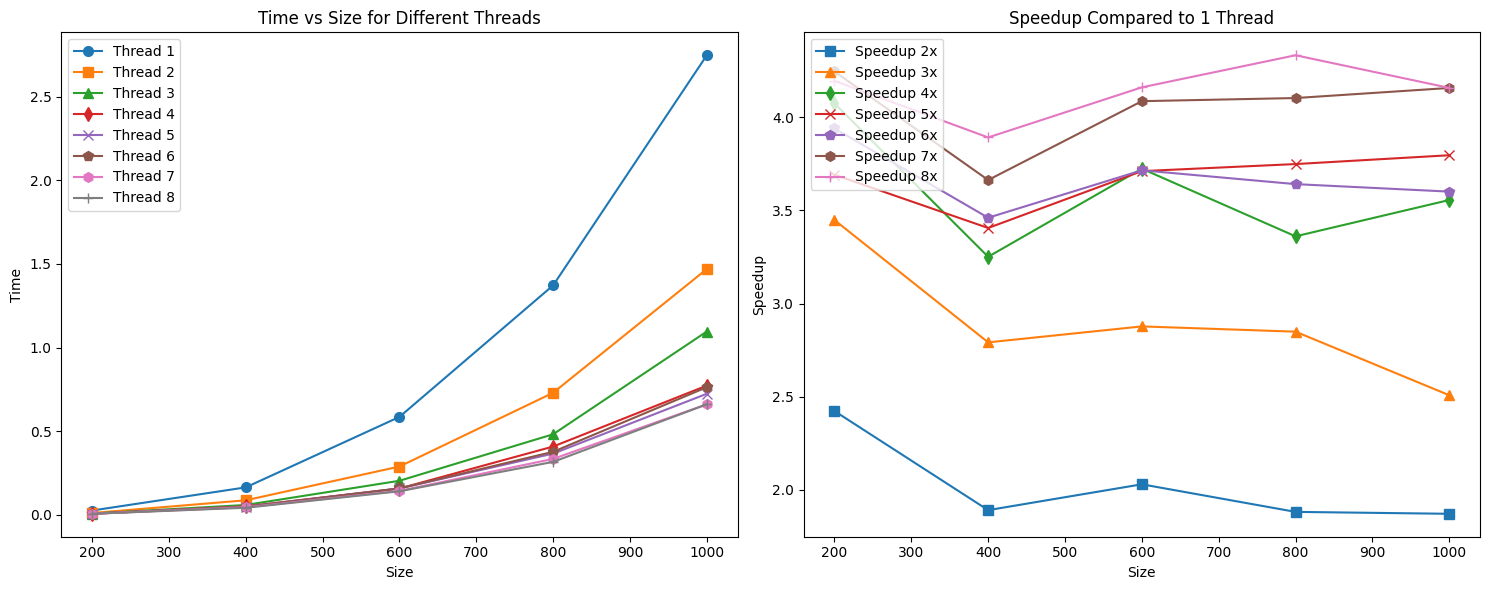

In [ ]:
file_name = "./mm_openMP.txt"
plot_function_openmp(file_name)

### MPI

In [8]:
%%writefile mm-mpi.c
#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <mpi.h>

void writeResultsToFile(int size, double time_spend, int num_processors) {
    FILE *output_file = fopen("./mm_mpi.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    }

    fprintf(output_file, "%d %lf %d ", size, time_spend, num_processors);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void mms(double *a, int fa, int ca, int lda, double *b, int fb, int cb, int ldb, double *c, int fc, int cc, int ldc) {
    int i, j, k;
    double s;
    for (i = 0; i < fa; i++)
        for (j = 0; j < cb; j++) {
            s = 0.;
            for (k = 0; k < ca; k++)
                s += a[i * lda + k] * b[k * ldb + j];
            c[i * ldc + j] = s;
        }
}

void mm(double *a, int fa, int ca, int lda, double *b, int fb, int cb, int ldb, double *c, int fc, int cc, int ldc, int nodo, int np) {
    int i, j, k;
    double s;
    if (nodo == 0) {
        for (i = 1; i < np; i++)
            MPI_Send(&a[i * lda * fa / np], fa / np * ca, MPI_DOUBLE, i, 20, MPI_COMM_WORLD);
        MPI_Bcast(b, fb * cb, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    } else {
        MPI_Recv(a, fa / np * ca, MPI_DOUBLE, 0, 20, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        MPI_Bcast(b, fb * cb, MPI_DOUBLE, 0, MPI_COMM_WORLD);
    }
    mms(a, fa / np, ca, lda, b, fb, cb, ldb, c, fc / np, cc, ldc);
    if (nodo == 0)
        for (i = 1; i < np; i++)
            MPI_Recv(&c[i * ldc * fc / np],fc / np * cc, MPI_DOUBLE, i, 30, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
    else
        MPI_Send(c, fc / np * cc, MPI_DOUBLE, 0, 30, MPI_COMM_WORLD);
}

/*
c
c initialize - random initialization for array
c
*/

void initialize(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {
      m[i * ld + j] = (double)(i + j);
    }
  }
}

void initializealea(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {
      m[i * ld + j] = (double)rand() / RAND_MAX;
    }
  }
}

void escribir(double *m, int f, int c, int ld) {
  int i, j;

  for (i = 0; i < f; i++) {
    for (j = 0; j < c; j++) {
      printf("%.4lf ",m[i * ld + j]);
    }
    printf("\n");
  }
}

void comparar(double *m1, int fm1, int cm1, int ldm1, double *m2, int fm2, int cm2, int ldm2)
{
  int i, j;

  for(i = 0; i < fm1; i++)
    for(j = 0; j < cm1; j++) {
      if(m1[i * ldm1 + j] != m2[i * ldm2 + j]) {
        printf("Discrepance in %d,%d: %.8lf , %.8lf\n", i, j, m1[i * ldm1 + j], m2[i * ldm2 + j]);
        return;
      }
    }
}

int main(int argc, char *argv[]) {
  int nodo, np, i, j, fa, fal, ca, lda, fb, cb, ldb, fc, fcl, cc, ldc, N;
  int long_name;
  double ti, tf;
  double *a, *b, *c, *c0;
  char    nombre_procesador[MPI_MAX_PROCESSOR_NAME];
  MPI_Status estado;

  MPI_Init(&argc, &argv);
  MPI_Comm_size(MPI_COMM_WORLD, &np);
  MPI_Comm_rank(MPI_COMM_WORLD, &nodo);
  MPI_Get_processor_name(nombre_procesador, &long_name);

  if (nodo == 0) {
    N = atoi(argv[1]);
  }
  MPI_Bcast(&N, 1, MPI_INT, 0, MPI_COMM_WORLD);

  fa = ca = lda = fb = cb = ldb = fc = cc = ldc = N;
  fal = N / np;
  fcl = N / np;
  if (nodo == 0) {
    a = (double *) malloc(sizeof(double) * fa * ca);
    b = (double *) malloc(sizeof(double) * fb * cb);
    c = (double *) malloc(sizeof(double) * fc * cc);
  } else {
    a = (double *) malloc(sizeof(double) * fal * ca);
    b = (double *) malloc(sizeof(double) * fb * cb);
    c = (double *) malloc(sizeof(double) * fcl * cc);
  }

  if (nodo == 0) {
    c0 = (double *) malloc(sizeof(double) * fc * cc);
    initialize(a, fa, ca, lda);
    initialize(b, fb, cb, ldb);

    mms(a, fa, ca, lda, b, fb, cb, ldb, c0, fc, cc, ldc);
  }

  MPI_Barrier(MPI_COMM_WORLD);

  ti = MPI_Wtime();

  mm(a, fa, ca, lda, b, fb, cb, ldb, c, fc, cc, ldc, nodo, np);

  MPI_Barrier(MPI_COMM_WORLD);
  tf = MPI_Wtime();
  if (nodo == 0) {
    //printf("(%d) Process %d, %s, Time %.6lf\n", N, np, nombre_procesador, tf - ti);
    //printf("%d\t%f\t%d\n", N, tf - ti, np);
    writeResultsToFile(N, tf - ti, np);
  }

  free(a);
  free(b);
  free(c);

  if (nodo == 0)
    free(c0);
  MPI_Finalize();
}

Writing mm-mpi.c


#### Run the code

In [13]:
%%writefile ./script_mm_mpi.sh
#!/bin/sh

for ((i=1; i<=32; i*=2))
do
  for ((j=200; j<=1000; j+=200))
  do
    mpirun --allow-run-as-root -np "$i" ./mm-mpi "$j"
  done
  echo
done

Overwriting ./script_mm_mpi.sh


In [107]:
!rm ./mm_mpi.txt

!bash ./script_mm_mpi.sh

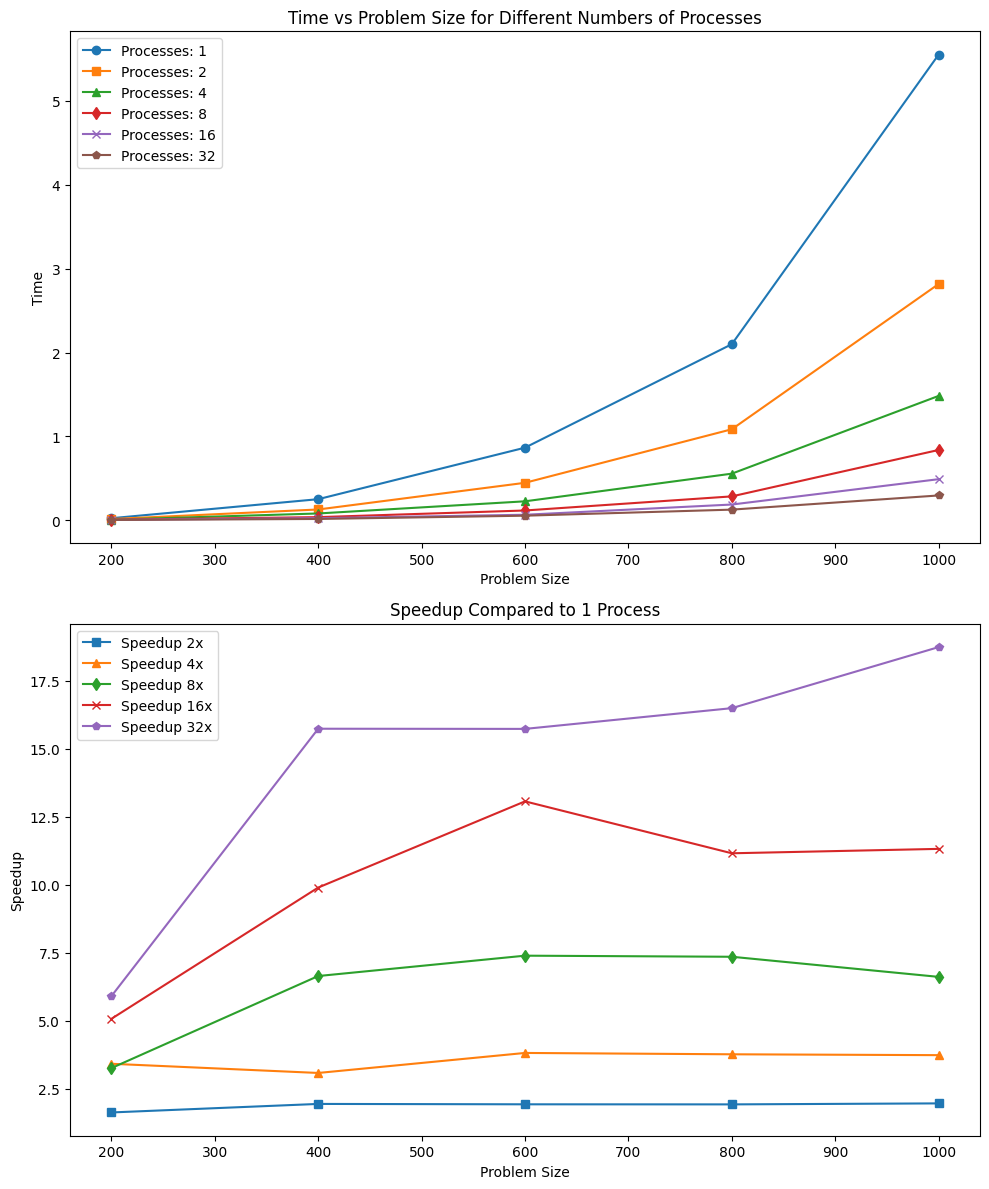

In [108]:
file_name = "./mm_mpi.txt"
plot_function_mpi(file_name)

### MPI + OpenMP

In [109]:
%%writefile ./mm-mpi_openmp.c

#include <stdio.h>
#include <stdlib.h>
#include <sys/time.h>
#include <mpi.h>
#include <omp.h>

void writeResultsToFile(int size, double time_spend, int num_processors, int num_threads) {
    FILE *output_file = fopen("./mm-mpi_openmp.txt", "a");
    if (output_file == NULL) {
        perror("Erro ao abrir o arquivo de saída");
        return;
    }

    fprintf(output_file, "%d %lf %d %d ", size, time_spend, num_threads, num_processors);
    if(size == 1000) fprintf(output_file, "\n");

    fclose(output_file);
}

void mm(double *a, int fa,int ca,int lda,double *b,int fb,int cb,int ldb,double *c,int fc,int cc,int ldc,int nodo,char *maquina)
{
  int i, j, k;
  double s;

 #pragma omp parallel
 {
   #pragma omp for private(i,j,k,s) schedule(static)
    for (i = 0; i < fa; i++)
    {
     for(j=0;j<cb;j++)
     {
      s=0.;
      for (k = 0; k < ca; k++)
      s = s+a[i*lda+k]*b[k*ldb+j];
      c[i*ldc+j]=s;
     }
    }
   }
  }

/*
c
c initialize - random initialization for array
c
*/

void initialize(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {
      m[i*ld+j] = (double)(i+j);
    }
  }
}

void initializealea(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {
      m[i*ld+j] = (double)rand()/RAND_MAX;
    }
  }

}

void escribir(double *m, int f,int c,int ld)
{
  int i, j;

  for (i = 0; i < f; i++)
  {
    for (j = 0; j < c; j++)
    {
      printf("%.4lf ",m[i*ld+j]);
    }
    printf("\n");
  }

}
/*
c
c     mseconds - returns elapsed milliseconds since Jan 1st, 1970.
c
*/
long long mseconds(){
  struct timeval t;
  gettimeofday(&t, NULL);
  return t.tv_sec*1000 + t.tv_usec/1000;
}

void comparar(double *m1,int fm1,int cm1,int ldm1,double *m2,int fm2,int cm2,int ldm2)
{
  int i,j;

  for(i=0;i<fm1;i++)
    for(j=0;j<cm1;j++)
    {
      if(m1[i*ldm1+j]!=m2[i*ldm2+j])
      {
        printf("Discrepance in %d,%d: %.8lf , %.8lf\n",i,j,m1[i*ldm1+j],m2[i*ldm2+j]);
        return;
      }
    }

}

int main(int argc,char *argv[])
{
  int nodo,np,i, j,fa,fal,ca,lda,fb,cb,ldb,fc,fcl,cc,ldc,N,NUMTHREADS;
  int long_name;
  double ti,tf;
  double *a,*b,*c,*c0;
  char    nombre_procesador[MPI_MAX_PROCESSOR_NAME];
  MPI_Status estado;

  MPI_Init(&argc,&argv);
  MPI_Comm_size(MPI_COMM_WORLD,&np);
  MPI_Comm_rank(MPI_COMM_WORLD,&nodo);
  MPI_Get_processor_name(nombre_procesador,&long_name);

  if(nodo==0)
  {
    N=atoi(argv[1]);
    NUMTHREADS=atoi(argv[2]);
  }

  MPI_Bcast(&N,1,MPI_INT,0,MPI_COMM_WORLD);
  MPI_Bcast(&NUMTHREADS,1,MPI_INT,0,MPI_COMM_WORLD);
  omp_set_num_threads(NUMTHREADS);

  fa=ca=lda=fb=cb=ldb=fc=cc=ldc=N;
  fal=N/np;
  fcl=N/np;
  if(nodo==0)
  {
    a = (double *) malloc(sizeof(double)*fa*ca);
    b = (double *) malloc(sizeof(double)*fb*cb);
    c = (double *) malloc(sizeof(double)*fc*cc);
  }
  else
  {
    a = (double *) malloc(sizeof(double)*fal*ca);
    b = (double *) malloc(sizeof(double)*fb*cb);
    c = (double *) malloc(sizeof(double)*fcl*cc);
  }

  if(nodo==0)
  {
    c0=(double *) malloc(sizeof(double)*fc*cc);
    initialize(a,fa,ca,lda);
    for(i=1;i<np;i++)
    {
      MPI_Send(&a[i*lda*N/np],fal*ca,MPI_DOUBLE,i,20,MPI_COMM_WORLD);
    }
    initialize(b,fb,cb,ldb);
    MPI_Bcast(b,fb*cb,MPI_DOUBLE,0,MPI_COMM_WORLD);
    mm(a,fa,ca,lda,b,fb,cb,ldb,c0,fc,cc,ldc,nodo,nombre_procesador);
  }
  else
  {
    MPI_Recv(a,fal*ca,MPI_DOUBLE,0,20,MPI_COMM_WORLD,&estado);
    MPI_Bcast(b,fb*cb,MPI_DOUBLE,0,MPI_COMM_WORLD);
  }

  MPI_Barrier(MPI_COMM_WORLD);

  ti=MPI_Wtime();

  mm(a,fal,ca,lda,b,fb,cb,ldb,c,fcl,cc,ldc,nodo,nombre_procesador);

  MPI_Barrier(MPI_COMM_WORLD);
  tf=MPI_Wtime();
  if(nodo==0)
  {
   //printf("(%d) Threads %d, Process %d, %s, Time %.6lf\n\n",N, NUMTHREADS, np, nombre_procesador,tf-ti);
    writeResultsToFile(N, tf-ti, np, NUMTHREADS);

    //printf("%d\t%f\n", N, tf-ti);
    for(i=1;i<np;i++)
    {
      MPI_Recv(&c[i*ldc*N/np],fcl*cc,MPI_DOUBLE,i,30,MPI_COMM_WORLD,&estado);
    }
  }
  else
  {
    MPI_Send(c,fcl*cc,MPI_DOUBLE,0,30,MPI_COMM_WORLD);
  }

  free(a);
  free(b);
  free(c);
  if(nodo==0)
    free(c0);
  MPI_Finalize();
}

Overwriting ./mm-mpi_openmp.c


#### Run the Code

In [110]:
!mpicc ./mm-mpi_openmp.c -o ./mm-mpi_openmp -fopenmp

In [111]:
%%writefile ./mm-mpi_openmp.sh
#!/bin/sh

for ((i=1; i<=32; i*=2)) # num_threads
do
    for ((j=1; j<=4; j*=2)) # num_processors
    do

        if [ "$i" == 1 ] && [ "$j" == 2 ]; then
            break
        fi

        for ((k=200; k<=1000; k+=200))
        do
            mpirun --allow-run-as-root -np "$j" ./mm-mpi_openmp "$k" "$i"
        done

    done
done

Overwriting ./mm-mpi_openmp.sh


In [112]:
!rm ./mm-mpi_openmp.txt
!bash ./mm-mpi_openmp.sh

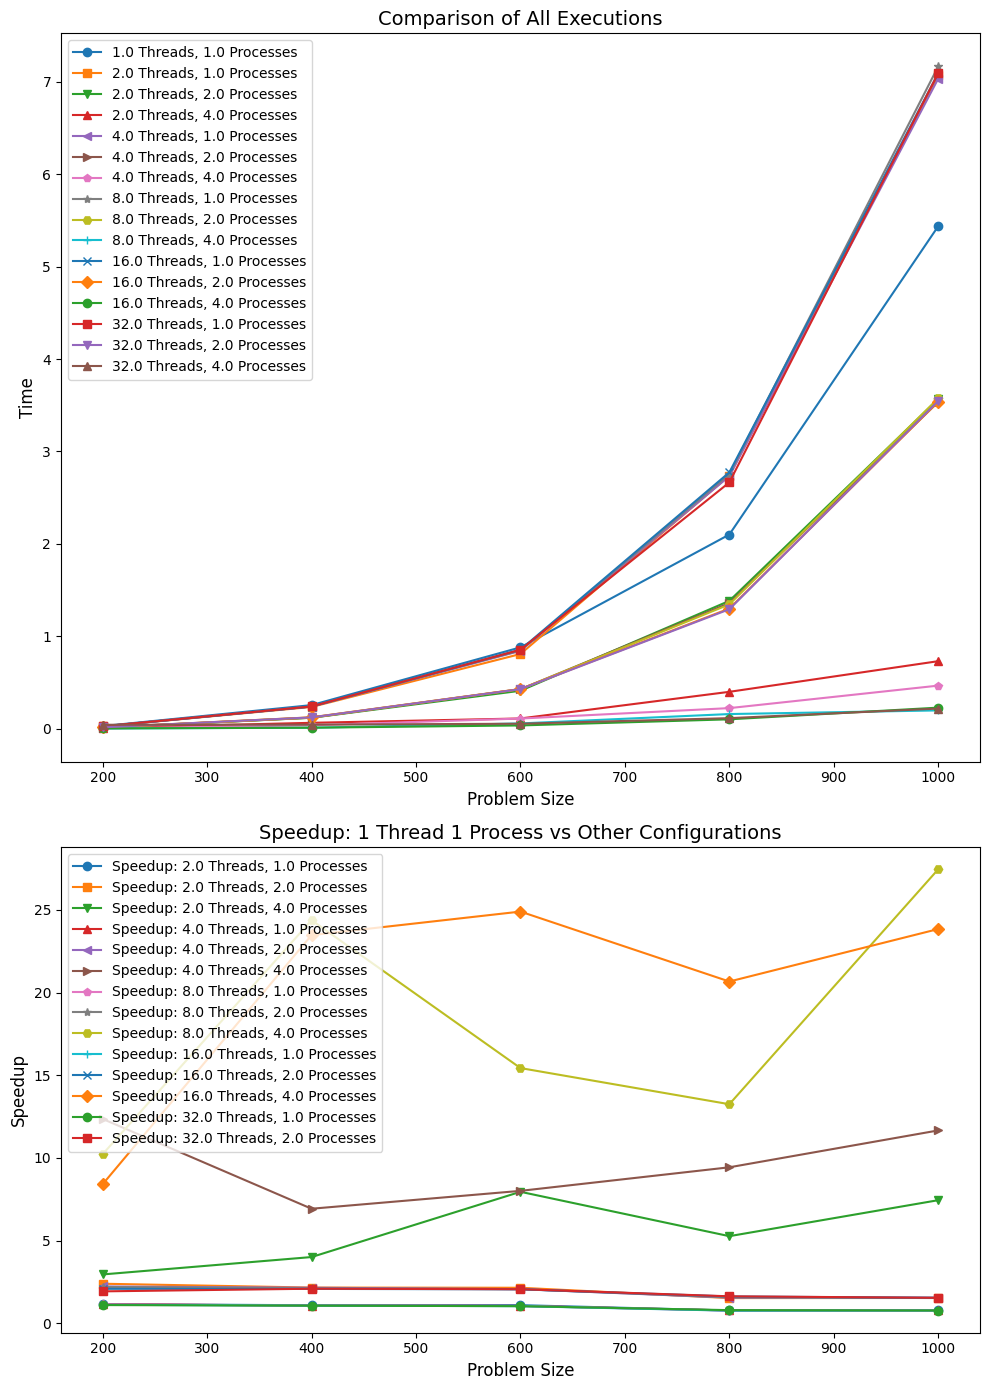

In [113]:
file_name = "./mm-mpi_openmp.txt"
plot_function_mpi_openmp(file_name)

## References

M. Boratto. *Hands-On Supercomputing with Parallel Computing*.
Available:
<https://github.com/muriloboratto/Hands-On-Supercomputing-with-Parallel-Computing>.
2022.

Forum, Message Passing Interface. *MPI: A Message-Passing Interface
Standard*. University of Tennessee, 1994, USA.

B. Chapman, G. Jost and R. Pas. *Using OpenMP: Portable Shared Memory
Parallel Programming*. The MIT Press, 2007, USA.